import and pip necessary libraries

In [1]:
import pandas as pd 
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

! pip install scikit-surprise
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise.model_selection import cross_validate

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


Read Data

In [2]:
df = pd.read_csv("ratings_Electronics.csv", names=["userId", "productId", "rating", "timestamp"])  
df.head() 

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
# Display dataset information and basic statistics
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB
None
             rating     timestamp
count  7.824482e+06  7.824482e+06
mean   4.012337e+00  1.338178e+09
std    1.380910e+00  6.900426e+07
min    1.000000e+00  9.127296e+08
25%    3.000000e+00  1.315354e+09
50%    5.000000e+00  1.361059e+09
75%    5.000000e+00  1.386115e+09
max    5.000000e+00  1.406074e+09


Data Preprocess

In [4]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check for duplicate rows
print("Duplicate rows:\n", df.duplicated().sum())

Missing values:
 userId       0
productId    0
rating       0
timestamp    0
dtype: int64
Duplicate rows:
 0


In [5]:
# Drop duplicate rows, if any
df = df.drop_duplicates()

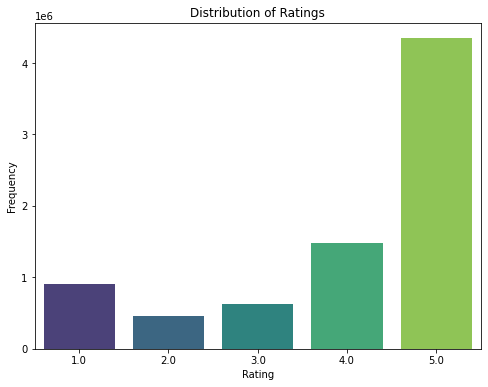

In [6]:
# Explore the distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Data Filter

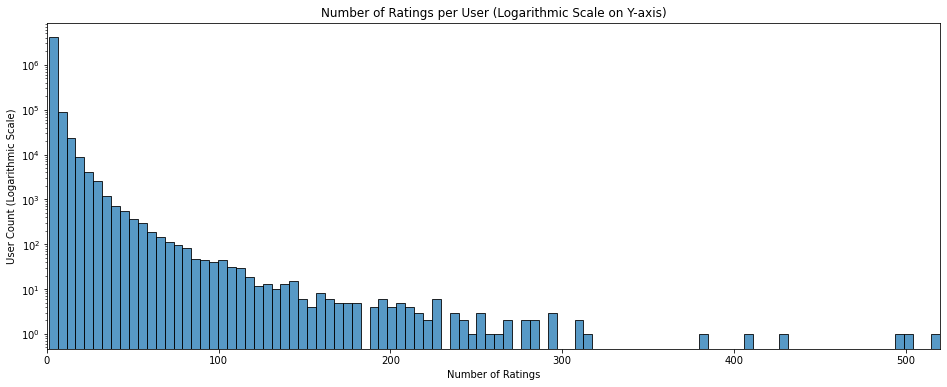

In [7]:
# Explore the number of ratings per user
user_ratings_count = df['userId'].value_counts()
plt.figure(figsize=(16, 6))
sns.histplot(user_ratings_count, kde=False, bins=100, log_scale=(False, True))
plt.title('Number of Ratings per User (Logarithmic Scale on Y-axis)')
plt.xlabel('Number of Ratings')
plt.ylabel('User Count (Logarithmic Scale)')
plt.xlim(0, user_ratings_count.max())
plt.show()

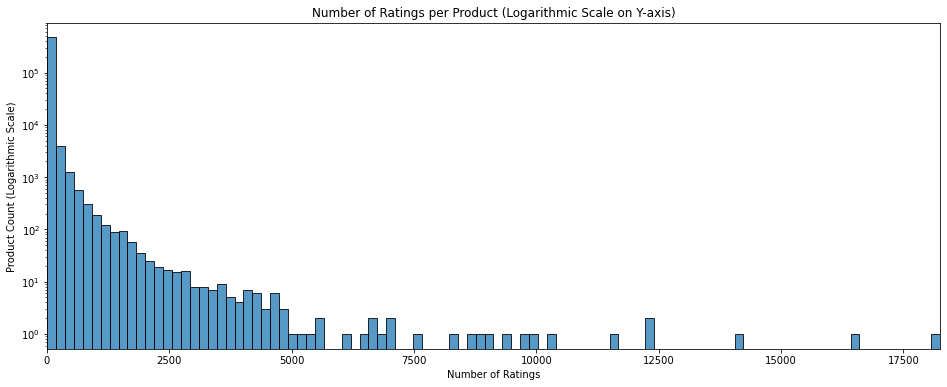

In [8]:
# Explore the number of ratings per product
product_ratings_count = df['productId'].value_counts()
plt.figure(figsize=(16, 6))
sns.histplot(product_ratings_count, kde=False, bins=100, log_scale=(False, True))
plt.title('Number of Ratings per Product (Logarithmic Scale on Y-axis)')
plt.xlabel('Number of Ratings')
plt.ylabel('Product Count (Logarithmic Scale)')
plt.xlim(0, product_ratings_count.max())
plt.show()

In [9]:
# Filter users and products with a minimum number of ratings
# we set min user ratings as 5 and min product ratings as 10
min_user_ratings = 5
min_product_ratings = 20

filtered_users = user_ratings_count[user_ratings_count >= min_user_ratings].index
filtered_products = product_ratings_count[product_ratings_count >= min_product_ratings].index

filtered_data = df[(df['userId'].isin(filtered_users)) & (df['productId'].isin(filtered_products))]

# Print the shape of the original and filtered data
print(f"Original data shape: {df.shape}")
print(f"Filtered data shape: {filtered_data.shape}")

Original data shape: (7824482, 4)
Filtered data shape: (1828344, 4)


EDA

In [10]:
# basic data information
print("Data shape:", filtered_data.shape)
print("\nData types:\n", filtered_data.dtypes)
print("\nMissing values:\n", filtered_data.isnull().sum())

Data shape: (1828344, 4)

Data types:
 userId        object
productId     object
rating       float64
timestamp      int64
dtype: object

Missing values:
 userId       0
productId    0
rating       0
timestamp    0
dtype: int64


In [11]:
# data statistics information
print("\nSummary statistics for numerical features:\n", filtered_data.describe())

print("\nFrequency distribution for categorical features:")
for col in filtered_data.select_dtypes(include=['object']):
    print(f"\n{col}:\n{filtered_data[col].value_counts()}")


Summary statistics for numerical features:
              rating     timestamp
count  1.828344e+06  1.828344e+06
mean   4.209477e+00  1.340618e+09
std    1.200339e+00  6.384993e+07
min    1.000000e+00  9.292320e+08
25%    4.000000e+00  1.318464e+09
50%    5.000000e+00  1.361059e+09
75%    5.000000e+00  1.385251e+09
max    5.000000e+00  1.406074e+09

Frequency distribution for categorical features:

userId:
ADLVFFE4VBT8      395
A3OXHLG6DIBRW8    375
A6FIAB28IS79      352
A5JLAU2ARJ0BO     329
A680RUE1FDO8B     325
                 ... 
ACFY333M2KDBO       1
A3DDU7E893MEJG      1
A1M7376BKSSLR3      1
A22JQ5VSW1RML8      1
A1QDNA03IMP9CQ      1
Name: userId, Length: 253613, dtype: int64

productId:
B007WTAJTO    5483
B003ES5ZUU    4480
B00DR0PDNE    4283
B0019EHU8G    3836
B002WE6D44    3107
              ... 
B005GM5OXA       1
B003L9WPUU       1
B003MG07O8       1
B004G5NC6E       1
B0011FV3PY       1
Name: productId, Length: 57586, dtype: int64


In [12]:
# check unique values
print(f"Number of unique users: {filtered_data['userId'].nunique()}")
print(f"Number of unique products: {filtered_data['productId'].nunique()}")

Number of unique users: 253613
Number of unique products: 57586


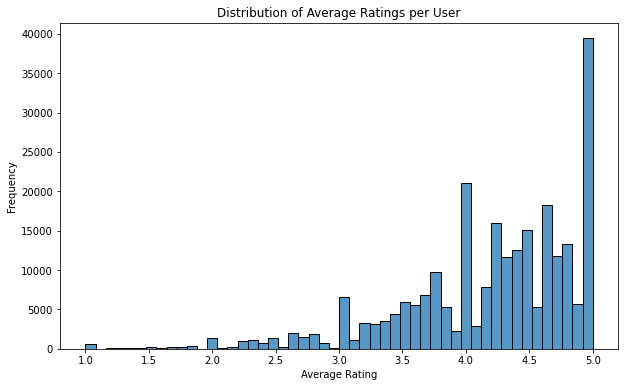

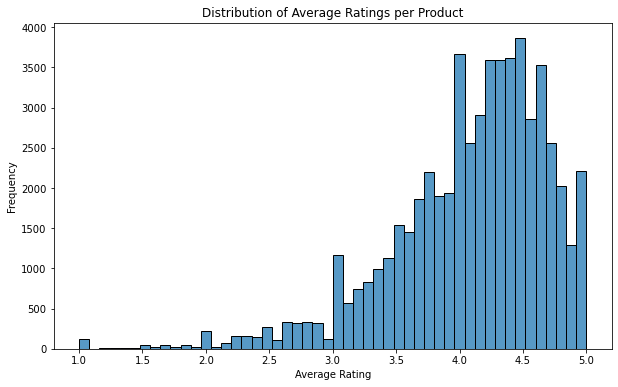

In [13]:
product_rating_agg = filtered_data.groupby('productId')['rating'].agg(['mean', 'count']).reset_index()

user_rating_agg = filtered_data.groupby('userId')['rating'].agg(['mean', 'count']).reset_index()

plt.figure(figsize=(10, 6))
sns.histplot(user_rating_agg['mean'], bins=50, kde=False)
plt.title('Distribution of Average Ratings per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(product_rating_agg['mean'], bins=50, kde=False)
plt.title('Distribution of Average Ratings per Product')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

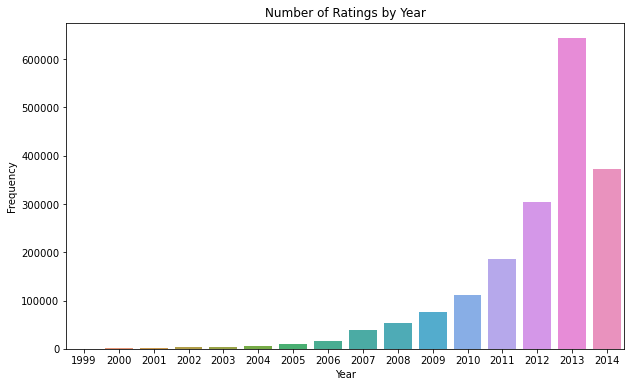

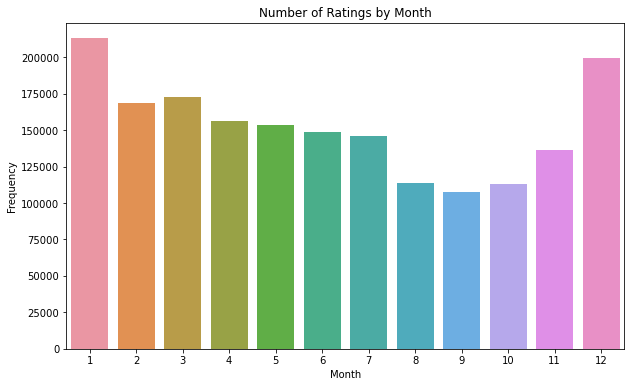

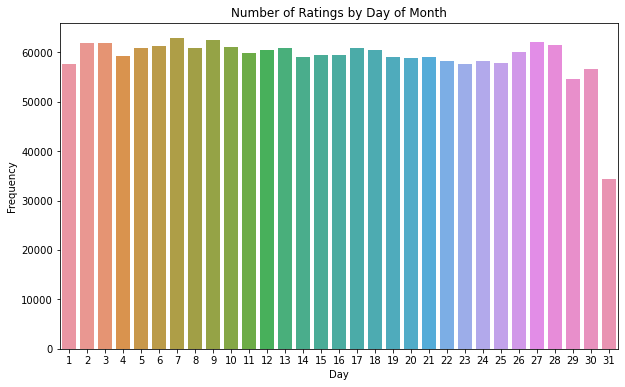

In [14]:
data_with_datetime = filtered_data.copy()

# Convert the 'timestamp' column to a datetime object
data_with_datetime['datetime'] = data_with_datetime['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

# Extract year, month, day, and hour information
data_with_datetime['year'] = data_with_datetime['datetime'].dt.year
data_with_datetime['month'] = data_with_datetime['datetime'].dt.month
data_with_datetime['day'] = data_with_datetime['datetime'].dt.day



# Visualize the distribution of ratings by year, month, day, and hour
plt.figure(figsize=(10, 6))
sns.countplot(x='year', data=data_with_datetime)
plt.title('Number of Ratings by Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='month', data=data_with_datetime)
plt.title('Number of Ratings by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='day', data=data_with_datetime)
plt.title('Number of Ratings by Day of Month')
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.show()

Item-Item Collaborative Filtering model

Transfer data into Surprise format, and split train and test data

In [15]:
reader = Reader(rating_scale=(1, 5))

surprise_data = Dataset.load_from_df(filtered_data[['userId', 'productId', 'rating']], reader)

trainset, testset = train_test_split(surprise_data, test_size=0.3, random_state=42)

Basic KNN

In [16]:
'''
param_grid = {
    'k': [10, 20, 30, 40, 50],
    'sim_options': {
        'name': ['cosine'],
        'user_based': [False]
    }
}
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs.fit(surprise_data)
best_params = gs.best_params['rmse']
best_scores = gs.best_score['rmse']
print("Best parameters:", best_params)
print("Best RMSE:", best_scores)
'''
# Record the start time
start_time = time.time()

# Train the basic KNN model
basic_knn = KNNBasic(k=10, sim_options={'name': 'cosine', 'user_based': False})
basic_knn.fit(trainset)

# Calculate and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Test the model on the test set
predictions = basic_knn.test(testset)

# Calculate the accuracy measures
mae = accuracy.mae(predictions)
mse = accuracy.mse(predictions)
rmse = accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Elapsed time: 132.31 seconds
MAE:  0.8987
MSE: 1.6284
RMSE: 1.2761


KNN Baseline

In [17]:
'''
gs_base = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs_base.fit(surprise_data)
best_params = gs_base.best_params['rmse']
best_scores = gs_base.best_score['rmse']
print("Best parameters:", best_params)
print("Best RMSE:", best_scores)
'''

# Record the start time
start_time = time.time()

# Train the best k-NN model using the best parameters
base_knn = KNNBaseline(k=10, sim_options={'name': 'cosine', 'user_based': False})
base_knn.fit(trainset)

# Calculate and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Test the model on the test set
predictions = base_knn.test(testset)

# Calculate the accuracy measures
mae = accuracy.mae(predictions)
mse = accuracy.mse(predictions)
rmse = accuracy.rmse(predictions)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Elapsed time: 135.68 seconds
MAE:  0.8565
MSE: 1.4343
RMSE: 1.1976


SVD

In [18]:
#svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)
svd_model = SVD()

# Training the algorithm on the trainset
svd_model.fit(trainset)

# Predicting for test set
predictions_svd = svd_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVD on 3 split(s) by cross validation
svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

# Storing Crossvalidation Results in dataframe
svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()
svd_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'], 
                           svd_described['fit_time']['mean'], svd_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])
svd_results

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1221  1.1231  1.1229  1.1227  0.0004  
MAE (testset)     0.8394  0.8406  0.8406  0.8402  0.0006  
Fit time          68.70   69.47   69.28   69.15   0.33    
Test time         6.44    6.39    6.26    6.36    0.07    


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,1.122689,0.840215,69.152889,6.363325
